In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
#from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)
import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import plotly.plotly as py

df = pd.read_csv('application_train.csv')
test_df = pd.read_csv('application_test.csv')
cc = pd.read_csv('credit_card_balance.csv')
pos = pd.read_csv('POS_CASH_balance.csv')
ins = pd.read_csv('installments_payments.csv')
bureau = pd.read_csv('bureau.csv')
bb = pd.read_csv('bureau_balance.csv')
prev = pd.read_csv('previous_application.csv')

print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
print("Credit Card: {}, POS: {}, installments samples: {}".format(len(cc), len(pos), len(ins)))
print("Bureau info: {}, balance: {}".format(len(bureau), len(bb)))

In [57]:
def one_hot_encoder(df):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def phone_group (row):
    if 0<= row['phone'] <= 1:
        return 0

    if 1<= row['phone'] <= 2:
        return 1

    if 2<= row['phone'] <= 3:
        return 2

    if 3<= row['phone'] <= 5: 
        return 3
    
    if 5<= row['phone'] <= 13:
        return 4

    else:
        return 5


def family_group (row):
    if  row['CNT_FAM_MEMBERS'] == 0:
        return '0'

    if row['CNT_FAM_MEMBERS'] == 1:
        return '1'

    if row['CNT_FAM_MEMBERS'] == 2:
        return '2'

    if row['CNT_FAM_MEMBERS'] == 3 : 
        return '3'
    
    if row['CNT_FAM_MEMBERS'] == 4:
        return '4'

    else:
        return 'vibrosi'

def region (row):
    if 0<= row['REGION_POPULATION_RELATIVE1'] < 5:
        return 'very_lo'

    if 5<= row['REGION_POPULATION_RELATIVE1'] < 10:
        return 'lo'

    if 10<= row['REGION_POPULATION_RELATIVE1'] <= 20: 
        return 'mid'
    
    if 20<= row['REGION_POPULATION_RELATIVE1'] <= 40:
        return 'hi_mid'

    if 40<= row['REGION_POPULATION_RELATIVE1'] <= 70: 
        return 'hi'
    
    else:
        return 'very_high'
    
def age_group (row):
    if 18<= row['age'] <= 22:
        return 'very_young'

    if 23<= row['age'] <= 30:
        return 'young'

    if 30<= row['age'] <= 40:
        return 'older_young'

    if 40<= row['age'] <= 55: 
        return 'adult'
    
    if 55<= row['age'] <= 85: 
        return 'super_puper_grand'
    
    else:
        return 'vibrosi'
    
def Employ (row):
    if 0<= row['DAYS_EMPLOYED'] <= 0.5:
        return 'malo'

    if 0.5<= row['DAYS_EMPLOYED'] <= 1:
        return 'young1'

    if 1<= row['DAYS_EMPLOYED'] <= 2:
        return 'older_young1'

    if 2<= row['DAYS_EMPLOYED'] <= 5: 
        return 'adult1'
    
    if 5<= row['DAYS_EMPLOYED'] <= 13:
        return 'mnogo'

    else:
        return 'vibrosi'


def REGISTR (row):
    if 0<= row['DAYS_REGISTRATION'] <= 1:
        return 'very_young2'

    if 1<= row['DAYS_REGISTRATION'] <= 2:
        return 'young2'

    if 2<= row['DAYS_REGISTRATION'] <= 5:
        return 'older_young2'

    if 5<= row['DAYS_REGISTRATION'] <= 7: 
        return 'adult2'
    
    if 7<= row['DAYS_REGISTRATION'] <= 13:
        return 'adult_plus2'

    else:
        return 'vibrosi2'
    
def ID_PUBLISH (row):
    if 0<= row['DAYS_ID_PUBLISH'] <= 1:
        return 'very_young3'

    if 1<= row['DAYS_ID_PUBLISH'] <= 3:
        return 'young3'

    if 3<= row['DAYS_ID_PUBLISH'] <= 5:
        return 'older_young3'

    if 5<= row['DAYS_ID_PUBLISH'] <= 7: 
        return 'adult3'
    
    if 7<= row['DAYS_ID_PUBLISH'] <= 13:
        return 'adult_plus3'

    else:
        return 'vibrosi3'
    
def IsWeekend (row):
    if row['WEEKDAY_APPR_PROCESS_START'] == 'SATURDAY':
        return 1
    
    if row['WEEKDAY_APPR_PROCESS_START'] == 'SANDAY':
        return 1
    
    else:
        return 0


def education (row): 
    if row['NAME_EDUCATION_TYPE'] == 'Higher education': 
        return 1
    if row['NAME_EDUCATION_TYPE'] == 'Academic degree': 
        return 1       
    else: 
        return 0
    
def family_stat (row): 
    if row['NAME_FAMILY_STATUS'] == 'Married': 
        return 1
    if row['NAME_FAMILY_STATUS'] == 'Civil marriage': 
        return 1
   
    else: 
        return 0 
    
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    
    return df_train, df_test




In [63]:
def apply_f(df):
    
    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f)]
    flat = [_f for _f in df.columns if ('_AVG' in _f) or ('_MODE' in _f) or ('_MEDI' in _f)]
    sourse = [_f for _f in df.columns if '_SOURCE_' in _f]
    bureau_amt =  [_f for _f in df.columns if 'AMT_REQ_CREDIT_BUREAU_' in _f]

    df = df[df['CODE_GENDER'] != 'XNA']

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    # features percentages
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # features for categorize
    df['DAYS_EMPLOYED']=abs(df['DAYS_EMPLOYED']//365)
    df['DAYS_REGISTRATION']=abs(df['DAYS_REGISTRATION']//365)
    df['DAYS_ID_PUBLISH']=abs(df['DAYS_ID_PUBLISH']//365)
    df['age']=abs(df['DAYS_BIRTH']//365)
    df['phone']=abs(df['DAYS_LAST_PHONE_CHANGE']//365)

    # additional features
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_EMPLOY_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

    
    df['REGION_POPULATION_RELATIVE1']=df['REGION_POPULATION_RELATIVE']*1000
    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
    k = df[['AMT_INCOME_TOTAL','REGION_POPULATION_RELATIVE']].groupby('REGION_POPULATION_RELATIVE').median()['AMT_INCOME_TOTAL']
    df['NEW_INC_BY_RER'] = df['REGION_POPULATION_RELATIVE'].map(k)
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    
    df['NEW_DOC_IND_AVG'] = df[docs].mean(axis=1)
    df['NEW_DOC_IND_STD'] = df[docs].std(axis=1)

    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_LIVE_IND_STD'] = df[live].std(axis=1)

    df['FLAT_1'] = df[flat].sum(axis=1)
    df['FLAT_2'] = df[flat].std(axis=1)
    df['FLAT_3'] = df[flat].mean(axis=1)

    df['SOURCE_1'] = df[sourse].mean(axis=1)
    df['SOURCE_2'] = df[sourse].sum(axis=1)
    df['SOURCE_3'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']


    df['REG_RATING'] = df[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY']].mean(axis=1)
    
    df['w_h']=df['WEEKDAY_APPR_PROCESS_START'] + str(df['HOUR_APPR_PROCESS_START'])
    df['phone_group'] = df.apply(phone_group, axis=1)
    df['family_group'] = df.apply(family_group, axis=1)
    df['region_group'] = df.apply(region, axis=1)
    df['age_group'] = df.apply(age_group, axis=1)
    df['age_group'] = df.apply(age_group, axis=1)
    df['Employ'] = df.apply(Employ, axis=1)
    df['Registr'] = df.apply(REGISTR, axis=1)
    df['ID_publish'] = df.apply(ID_PUBLISH, axis=1)
    df['IsWeekend'] = df.apply(IsWeekend, axis=1)
    #df['bolshe']=df.apply(asf, axis=1)
    #df['car'] = df.apply(car, axis=1)
    #df['realty']=df.apply(realty, axis=1)
    #df['gender']=df.apply(gender, axis=1)
    df['education']=df.apply(education, axis=1)
    df['family_stat']=df.apply(family_stat, axis=1)
    
    df= df.drop(docs, axis=1)
    df=df.drop(live, axis=1)
    df=df.drop(flat, axis=1)    
    df=df.drop(['NAME_FAMILY_STATUS',
    'NAME_EDUCATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
    'DAYS_ID_PUBLISH',
    'DAYS_REGISTRATION',
    'DAYS_EMPLOYED',
    'age',
    'REGION_POPULATION_RELATIVE1',
    'phone'] , axis=1)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df[categorical_columns].fillna('0')
    
    
    return df, categorical_columns

In [59]:
df = pd.read_csv('application_train.csv')
tdf = pd.read_csv('application_test.csv')

In [65]:
df, categorial_columns =apply_f(df)
tdf, categorial_columns =apply_f(tdf)


/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4619: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/i

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

In [ ]:
cat_feat = list(df.dtypes[df.dtypes == object].index)
num_feat = [f for f in df if f not in cat_feat ]

for cat_feat in cat_feat:
    data_train, data_test = get_woe_v1(df, tdf, cat_feat, 'TARGET')

cat_feat1 = list(data_train.dtypes[data_train.dtypes == object].index)
data_train=data_train.drop(cat_feat1 , axis=1)
data_test=data_test.drop(cat_feat1 , axis=1)

In [171]:
data_train.to_csv('dt.csv')
data_test.to_csv('dte.csv')



In [98]:
y = data_train['TARGET']
del data_train['TARGET']

In [99]:
from sklearn.preprocessing import Imputer


imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data_train_X= imp.fit_transform(data_train)
data_test_X= imp.transform(data_test)


In [101]:
from sklearn.preprocessing import Imputer


imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
data_train_X= imp.fit_transform(data_train)
data_test_X= imp.transform(data_test)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
m=scaler.fit(data_train_X)
X_train=scaler.transform(data_train_X)
X_test=scaler.transform(data_test_X)

from catboost import CatBoostClassifier
model = CatBoostClassifier(logging_level='Verbose')
model.fit(X_train, y)

y_pred=model.predict_proba(X_test)
sample_submission=pd.read_csv('sample_submission-9.csv')
qq=data_test['SK_ID_CURR'].reset_index()
sample_submission['SK_ID_CURR']=qq['SK_ID_CURR']
sample_submission['TARGET']=y_pred
sample_submission.to_csv('sample_submission.csv', index=False)


In [102]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(logging_level='Verbose')
model.fit(X_train, y)



Learning rate set to 0.084759
0:	learn: 0.6003682	total: 292ms	remaining: 4m 52s
1:	learn: 0.5278479	total: 534ms	remaining: 4m 26s
2:	learn: 0.4709285	total: 787ms	remaining: 4m 21s
3:	learn: 0.4281165	total: 1.03s	remaining: 4m 16s
4:	learn: 0.3932009	total: 1.29s	remaining: 4m 16s
5:	learn: 0.3657532	total: 1.6s	remaining: 4m 25s
6:	learn: 0.3436856	total: 1.88s	remaining: 4m 26s
7:	learn: 0.3271168	total: 2.13s	remaining: 4m 23s
8:	learn: 0.3126577	total: 2.38s	remaining: 4m 21s
9:	learn: 0.3009007	total: 2.62s	remaining: 4m 19s
10:	learn: 0.2925918	total: 2.88s	remaining: 4m 18s
11:	learn: 0.2851974	total: 3.12s	remaining: 4m 17s
12:	learn: 0.2788930	total: 3.37s	remaining: 4m 15s
13:	learn: 0.2742009	total: 3.61s	remaining: 4m 14s
14:	learn: 0.2702501	total: 3.86s	remaining: 4m 13s
15:	learn: 0.2666126	total: 4.1s	remaining: 4m 12s
16:	learn: 0.2641100	total: 4.35s	remaining: 4m 11s
17:	learn: 0.2617725	total: 4.59s	remaining: 4m 10s
18:	learn: 0.2597123	total: 4.87s	remaining: 4

158:	learn: 0.2422896	total: 40.4s	remaining: 3m 33s
159:	learn: 0.2422614	total: 40.6s	remaining: 3m 33s
160:	learn: 0.2422446	total: 40.9s	remaining: 3m 32s
161:	learn: 0.2422326	total: 41.1s	remaining: 3m 32s
162:	learn: 0.2422036	total: 41.4s	remaining: 3m 32s
163:	learn: 0.2421798	total: 41.6s	remaining: 3m 32s
164:	learn: 0.2421594	total: 41.8s	remaining: 3m 31s
165:	learn: 0.2421327	total: 42.1s	remaining: 3m 31s
166:	learn: 0.2421243	total: 42.4s	remaining: 3m 31s
167:	learn: 0.2420728	total: 42.6s	remaining: 3m 31s
168:	learn: 0.2420467	total: 42.9s	remaining: 3m 30s
169:	learn: 0.2420205	total: 43.1s	remaining: 3m 30s
170:	learn: 0.2419947	total: 43.4s	remaining: 3m 30s
171:	learn: 0.2419759	total: 43.6s	remaining: 3m 30s
172:	learn: 0.2419583	total: 43.9s	remaining: 3m 29s
173:	learn: 0.2419367	total: 44.1s	remaining: 3m 29s
174:	learn: 0.2419164	total: 44.4s	remaining: 3m 29s
175:	learn: 0.2418934	total: 44.6s	remaining: 3m 28s
176:	learn: 0.2418705	total: 44.9s	remaining: 

312:	learn: 0.2387495	total: 1m 26s	remaining: 3m 9s
313:	learn: 0.2387308	total: 1m 26s	remaining: 3m 8s
314:	learn: 0.2387104	total: 1m 26s	remaining: 3m 8s
315:	learn: 0.2386788	total: 1m 26s	remaining: 3m 8s
316:	learn: 0.2386538	total: 1m 27s	remaining: 3m 8s
317:	learn: 0.2386123	total: 1m 27s	remaining: 3m 7s
318:	learn: 0.2385862	total: 1m 27s	remaining: 3m 7s
319:	learn: 0.2385600	total: 1m 28s	remaining: 3m 7s
320:	learn: 0.2385378	total: 1m 28s	remaining: 3m 7s
321:	learn: 0.2385071	total: 1m 28s	remaining: 3m 7s
322:	learn: 0.2384934	total: 1m 29s	remaining: 3m 6s
323:	learn: 0.2384804	total: 1m 29s	remaining: 3m 6s
324:	learn: 0.2384673	total: 1m 29s	remaining: 3m 6s
325:	learn: 0.2384428	total: 1m 29s	remaining: 3m 5s
326:	learn: 0.2384281	total: 1m 30s	remaining: 3m 5s
327:	learn: 0.2384092	total: 1m 30s	remaining: 3m 5s
328:	learn: 0.2383848	total: 1m 30s	remaining: 3m 4s
329:	learn: 0.2383699	total: 1m 30s	remaining: 3m 4s
330:	learn: 0.2383462	total: 1m 31s	remaining:

466:	learn: 0.2356770	total: 2m 13s	remaining: 2m 32s
467:	learn: 0.2356646	total: 2m 13s	remaining: 2m 31s
468:	learn: 0.2356398	total: 2m 13s	remaining: 2m 31s
469:	learn: 0.2356215	total: 2m 14s	remaining: 2m 31s
470:	learn: 0.2356009	total: 2m 14s	remaining: 2m 30s
471:	learn: 0.2355773	total: 2m 14s	remaining: 2m 30s
472:	learn: 0.2355543	total: 2m 14s	remaining: 2m 30s
473:	learn: 0.2355366	total: 2m 15s	remaining: 2m 29s
474:	learn: 0.2355136	total: 2m 15s	remaining: 2m 29s
475:	learn: 0.2354959	total: 2m 15s	remaining: 2m 29s
476:	learn: 0.2354822	total: 2m 15s	remaining: 2m 28s
477:	learn: 0.2354658	total: 2m 16s	remaining: 2m 28s
478:	learn: 0.2354402	total: 2m 16s	remaining: 2m 28s
479:	learn: 0.2354215	total: 2m 16s	remaining: 2m 27s
480:	learn: 0.2354006	total: 2m 16s	remaining: 2m 27s
481:	learn: 0.2353757	total: 2m 17s	remaining: 2m 27s
482:	learn: 0.2353644	total: 2m 17s	remaining: 2m 27s
483:	learn: 0.2353453	total: 2m 17s	remaining: 2m 26s
484:	learn: 0.2353175	total:

619:	learn: 0.2330378	total: 2m 54s	remaining: 1m 47s
620:	learn: 0.2330192	total: 2m 54s	remaining: 1m 46s
621:	learn: 0.2330081	total: 2m 55s	remaining: 1m 46s
622:	learn: 0.2329837	total: 2m 55s	remaining: 1m 46s
623:	learn: 0.2329661	total: 2m 55s	remaining: 1m 45s
624:	learn: 0.2329480	total: 2m 55s	remaining: 1m 45s
625:	learn: 0.2329391	total: 2m 56s	remaining: 1m 45s
626:	learn: 0.2329302	total: 2m 56s	remaining: 1m 44s
627:	learn: 0.2329194	total: 2m 56s	remaining: 1m 44s
628:	learn: 0.2329009	total: 2m 56s	remaining: 1m 44s
629:	learn: 0.2328936	total: 2m 57s	remaining: 1m 43s
630:	learn: 0.2328797	total: 2m 57s	remaining: 1m 43s
631:	learn: 0.2328684	total: 2m 57s	remaining: 1m 43s
632:	learn: 0.2328471	total: 2m 57s	remaining: 1m 43s
633:	learn: 0.2328237	total: 2m 58s	remaining: 1m 42s
634:	learn: 0.2328079	total: 2m 58s	remaining: 1m 42s
635:	learn: 0.2327932	total: 2m 58s	remaining: 1m 42s
636:	learn: 0.2327814	total: 2m 58s	remaining: 1m 41s
637:	learn: 0.2327619	total:

773:	learn: 0.2306117	total: 3m 35s	remaining: 1m 2s
774:	learn: 0.2305940	total: 3m 35s	remaining: 1m 2s
775:	learn: 0.2305754	total: 3m 35s	remaining: 1m 2s
776:	learn: 0.2305568	total: 3m 35s	remaining: 1m 1s
777:	learn: 0.2305467	total: 3m 36s	remaining: 1m 1s
778:	learn: 0.2305290	total: 3m 36s	remaining: 1m 1s
779:	learn: 0.2305233	total: 3m 36s	remaining: 1m 1s
780:	learn: 0.2305014	total: 3m 36s	remaining: 1m
781:	learn: 0.2304852	total: 3m 37s	remaining: 1m
782:	learn: 0.2304741	total: 3m 37s	remaining: 1m
783:	learn: 0.2304600	total: 3m 37s	remaining: 60s
784:	learn: 0.2304445	total: 3m 38s	remaining: 59.7s
785:	learn: 0.2304328	total: 3m 38s	remaining: 59.4s
786:	learn: 0.2304145	total: 3m 38s	remaining: 59.2s
787:	learn: 0.2303915	total: 3m 38s	remaining: 58.9s
788:	learn: 0.2303716	total: 3m 39s	remaining: 58.6s
789:	learn: 0.2303608	total: 3m 39s	remaining: 58.3s
790:	learn: 0.2303418	total: 3m 39s	remaining: 58s
791:	learn: 0.2303282	total: 3m 39s	remaining: 57.7s
792:	l

930:	learn: 0.2282191	total: 4m 14s	remaining: 18.9s
931:	learn: 0.2282073	total: 4m 14s	remaining: 18.6s
932:	learn: 0.2281874	total: 4m 14s	remaining: 18.3s
933:	learn: 0.2281841	total: 4m 15s	remaining: 18s
934:	learn: 0.2281759	total: 4m 15s	remaining: 17.8s
935:	learn: 0.2281592	total: 4m 15s	remaining: 17.5s
936:	learn: 0.2281529	total: 4m 15s	remaining: 17.2s
937:	learn: 0.2281390	total: 4m 16s	remaining: 16.9s
938:	learn: 0.2281228	total: 4m 16s	remaining: 16.7s
939:	learn: 0.2281035	total: 4m 16s	remaining: 16.4s
940:	learn: 0.2280937	total: 4m 16s	remaining: 16.1s
941:	learn: 0.2280782	total: 4m 17s	remaining: 15.8s
942:	learn: 0.2280702	total: 4m 17s	remaining: 15.6s
943:	learn: 0.2280539	total: 4m 17s	remaining: 15.3s
944:	learn: 0.2280377	total: 4m 17s	remaining: 15s
945:	learn: 0.2280249	total: 4m 18s	remaining: 14.7s
946:	learn: 0.2280121	total: 4m 18s	remaining: 14.5s
947:	learn: 0.2279946	total: 4m 18s	remaining: 14.2s
948:	learn: 0.2279756	total: 4m 18s	remaining: 13.

In [105]:
data_test

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_CREDIT_TO_ANNUITY_RATIO,NEW_CREDIT_TO_GOODS_RATIO,NEW_INC_PER_CHLD,NEW_EMPLOY_TO_BIRTH_RATIO,NEW_ANNUITY_TO_INCOME_RATIO,NEW_CAR_TO_BIRTH_RATIO,NEW_CAR_TO_EMPLOY_RATIO,NEW_PHONE_TO_BIRTH_RATIO,NEW_PHONE_TO_EMPLOY_RATIO,NEW_CREDIT_TO_INCOME_RATIO,NEW_INC_BY_RER,NEW_INC_BY_ORG,NEW_DOC_IND_AVG,NEW_DOC_IND_STD,NEW_LIVE_IND_SUM,NEW_LIVE_IND_STD,FLAT_1,FLAT_2,FLAT_3,SOURCE_1,SOURCE_2,SOURCE_3,REG_RATING,phone_group,IsWeekend,education,family_stat,NAME_CONTRACT_TYPE_woe,CODE_GENDER_woe,NAME_TYPE_SUITE_woe,NAME_INCOME_TYPE_woe,NAME_HOUSING_TYPE_woe,OCCUPATION_TYPE_woe,ORGANIZATION_TYPE_woe,w_h_woe,family_group_woe,region_group_woe,age_group_woe,Employ_woe,Registr_woe,ID_publish_woe
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,NaN,2.0,2,2,18,0,0,0,0,0,0,0.752614,0.789654,0.159520,0.0,0.0,0.0,0.0,-1740.0,0.0,0.0,0.0,0.0,0.0,0.0,0.121044,0.237342,67500.0,0.152300,0.036147,27.664697,1.264000,135000.0,-0.000364,0.152299,NaN,NaN,0.090432,-248.571429,4.213333,135000.0,135000.0,0.05,0.223607,4,0.516398,4.2810,0.334516,0.225316,0.567263,1.701788,0.094803,2.0,3,0,1,1,0.036222,-0.154321,0.014752,0.188682,-0.037950,NaN,-0.148715,None,-0.067846,0.056691,-0.101394,-0.148176,-0.136963,0.228477
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,NaN,2.0,2,2,9,0,0,0,0,0,0,0.564990,0.291656,0.432962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.247398,0.444409,49500.0,0.175455,0.077973,12.824870,1.237600,99000.0,-0.000720,0.175453,NaN,NaN,-0.000000,0.000000,2.250182,148500.0,157500.0,0.05,0.223607,3,0.547723,0.0000,NaN,NaN,0.429869,1.289607,0.071345,2.0,0,0,0,1,0.036222,0.250917,0.014752,0.188682,-0.037950,0.858184,0.254422,None,-0.067846,-0.018323,-0.101394,-0.148176,-0.136963,0.185330
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,5.0,2.0,2,2,14,0,0,0,0,0,0,NaN,0.699787,0.610991,0.0,0.0,0.0,0.0,-856.0,0.0,0.0,0.0,0.0,1.0,4.0,0.222477,0.305308,101250.0,0.344578,0.105202,9.505482,1.052800,202500.0,-0.000649,0.344576,-0.000250,0.384615,0.042719,-65.846154,3.275378,135000.0,180000.0,0.05,0.223607,3,0.547723,0.0000,NaN,NaN,0.655389,1.310778,NaN,2.0,2,0,1,1,0.036222,0.250917,NaN,0.188682,-0.037950,0.374619,0.755825,None,-0.067846,0.056691,-0.101394,-0.148176,0.086989,-0.101033
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,NaN,4.0,2,2,11,0,0,0,0,0,0,0.525734,0.509677,0.612704,0.0,0.0,0.0,0.0,-1805.0,0.0,0.0,0.0,0.0,0.0,3.0,0.133515,0.200000,78750.0,0.155614,0.031123,32.130726,1.000000,105000.0,-0.000429,0.155614,NaN,NaN,0.129150,-300.833333,5.000000,157500.0,180000.0,0.05,0.223607,4,0.516398,14.0111,0.288208,0.325840,0.549372,1.648115,0.164177,2.0,3,0,0,1,0.036222,-0.154321,0.014752,0.188682,-0.037950,0.193649,0.154884,None,0.075228,-0.018323,0.188103,-0.148176,0.086989,-0.101033
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,16.0,3.0,2,2,5,0,0,0,0,1,1,0.202145,0.425687,NaN,0.0,0.0,0.0,0.0,-821.0,NaN,NaN,NaN,NaN,NaN,NaN,0.168021,0.287770,60000.0,0.178150,0.051266,19.506034,1.000000,90000.0,-0.000537,0.178149,-0.001227,2.285714,0.062960,-117.285714,3.475000,180000.0,180000.0,0.05,0.223607,4,0.516398,0.0000,NaN,NaN,0.313916,0.627832,NaN,2.0,2,0,0,1,0.036222,0.250917,0.014752,0.188682,-0.037950,NaN,0.154884,None,0.08

In [112]:
y_pred=model.predict_proba(X_test)
sample_submission=pd.read_csv('sample_submission-9.csv')
qq=data_test['SK_ID_CURR'].reset_index()


In [113]:
y_pred=model.predict_proba(X_test)
sample_submission=pd.read_csv('sample_submission-9.csv')
qq=data_test['SK_ID_CURR'].reset_index()
sample_submission['SK_ID_CURR']=qq['SK_ID_CURR']
sample_submission['TARGET']=y_pred
sample_submission.to_csv('sample_submission.csv', index=False)

In [114]:
import xgboost as xgb

modelXGB = xgb.XGBClassifier(n_jobs=-1).fit(X_train, y)

y_pred=modelXGB.predict_proba(X_test)
sample_submission=pd.read_csv('sample_submission-9.csv')
qq=data_test['SK_ID_CURR'].reset_index()
sample_submission['SK_ID_CURR']=qq['SK_ID_CURR']
sample_submission['TARGET']=y_pred
sample_submission.to_csv('sample_submission.csv', index=False)

In [134]:
y_test=sample_submission['TARGET'].copy()

In [119]:
#y_pred=model.predict_proba(X_test)
sample_submission=pd.read_csv('sample_submission-9.csv')
qq=data_test['SK_ID_CURR'].reset_index()
sample_submission['SK_ID_CURR']=qq['SK_ID_CURR']
sample_submission['TARGET']=y_pred_svm_test
sample_submission.to_csv('sample_submission.csv', index=False)

In [125]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
clf_tree = DecisionTreeClassifier(max_depth=15, min_samples_leaf=20)
#clf_tree.fit(X_train, y_train)

In [143]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_leaf=20, max_features=0.8, n_jobs=-1)



In [146]:
from sklearn.linear_model import LinearRegression

In [147]:
lr = LinearRegression()

In [150]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('mean features...')
#for c in range(4):
 #   clf = MeanClassifier(c)
  #  
   # meta_tr, meta_te = get_meta_features(clf, X_train, y, X_test, stack_cv)
#
 #   meta_train.append(meta_tr)
  #  meta_test.append(meta_te)
   # col_names.append('mean_pred_{}'.format(c))

print('SVM features...')
meta_tr, meta_te = get_meta_features(clf_svm, X_train, y, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('svm_pred')

print('LR features...')
meta_tr, meta_te = get_meta_features(modelXGB, X_train, y, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_train, y, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

mean features...
SVM features...
LR features...
RF features...


In [152]:
meta_train

[array([0.51376444, 0.39282863, 0.39475122, ..., 0.39569856, 0.40594118,
        0.41072726]),
 array([0.37126374, 0.05832402, 0.03836795, ..., 0.05471659, 0.05184447,
        0.05411682], dtype=float32),
 array([0.5038172 , 0.06373556, 0.03849033, ..., 0.07876664, 0.11995733,
        0.09810138])]

In [160]:
X_meta_train.to_csv('X_meta_train.csv')
X_meta_test.to_csv('X_meta_test.csv')

In [153]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)


In [155]:
clf_lr_meta = LogisticRegression(penalty='l2', C=1)
clf_lr_meta.fit(X_meta_train, y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [157]:
y_pred_meta_test = clf_lr_meta.predict_proba(X_meta_test)[:, 1]


In [158]:
sample_submission=pd.read_csv('sample_submission-9.csv')
qq=data_test['SK_ID_CURR'].reset_index()
sample_submission['SK_ID_CURR']=qq['SK_ID_CURR']
sample_submission['TARGET']=y_pred_meta_test
sample_submission.to_csv('sample_submission.csv', index=False)

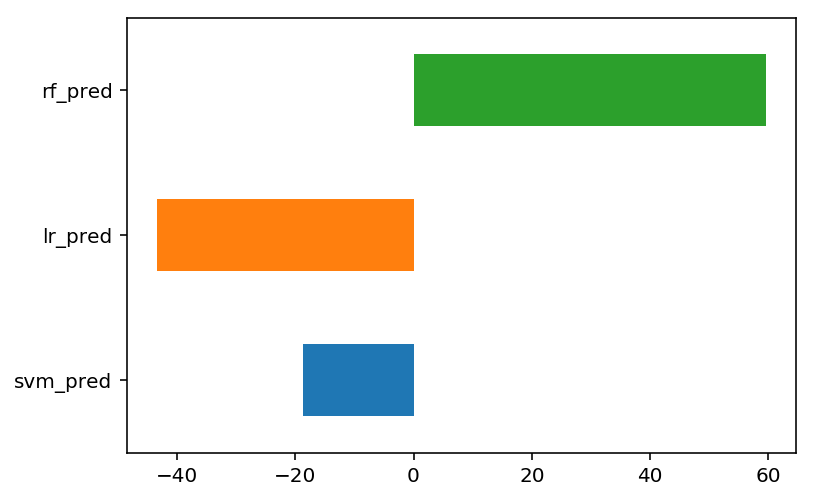

In [161]:
pd.Series(clf_lr_meta.coef_.flatten(), index=X_meta_train.columns).plot(kind='barh')